In [219]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
import astropy.units as u
import astropy.constants as c


%matplotlib inline

# RV

## Read in RV data for GJ 436 b

In [148]:
rv_data = astropy.io.ascii.read("/Users/huihaoz/Documents/23 sp/5205/project2/UID_0057087_RVC_003.tbl.txt")

## Plot the best-fit model

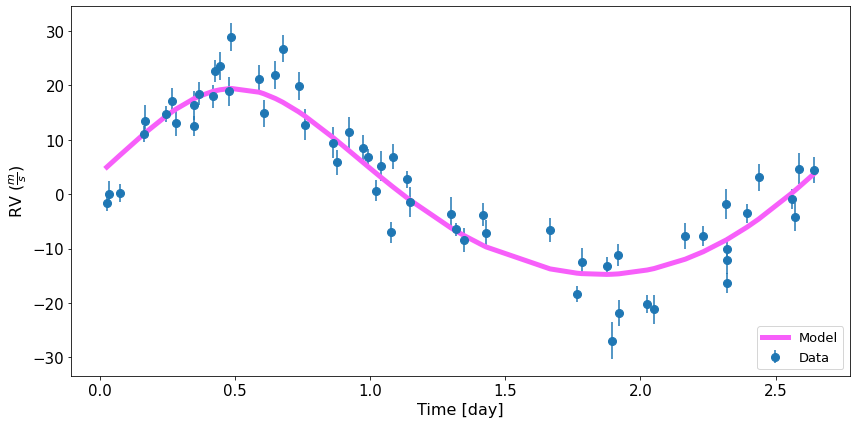

In [220]:
t = rv_data["JD"].data


import radvel
orbital_solution = [2.64388312, 2455959,  0.13827, 351 / 360.0 * 2 * np.pi, 17.09]
# Data come from NEA.
rvs = radvel.kepler.rv_drive(t, orbital_solution, use_c_kepler_solver=False)
    
per = 2.64388312

%matplotlib inline
# Fold data and plot model against data
ind = np.argsort(t % per)
plt.figure(figsize=(12, 6))
plt.errorbar(rv_data["JD"] % per, rv_data["Radial_Velocity"], rv_data["Radial_Velocity_Uncertainty"], 
             color="#1f77b4", ms=8, marker="o", ls="none", label="Data")
plt.plot((t % per)[ind], rvs[ind], "r-", label="Model", lw=5,color="#f75ffa")
plt.xlabel("Time [day]",fontdict={ 'size'   : 16})
plt.ylabel(r"RV ($\frac{m}{s}$)",fontdict={ 'size'   : 16})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(prop={'size': 13},loc=4)
plt.tight_layout()

We could get the value of k by find the semi-amplitude.

Here we use the mean value of a minimal 5 RV as the minimal RV

use the mean value of mean value of maximal 5 RV as the max RV

By equation: $K = \frac{RV_{max} - RV_{min}}{2}$

In [264]:
rvs.sort()

In [265]:
rvs[:4]

array([-14.74631654, -14.71628474, -14.65702987, -14.64099636])

In [266]:
rvs[-4:]

array([18.97391939, 19.17341038, 19.39293501, 19.41344249])

In [267]:
np.mean(rvs[-2:])

19.403188748279565

In [277]:
K = (np.mean(rvs[-5:])-np.min(rvs[:5]))/2
print(round(K,3),"m/s")

16.955 m/s


By equation: 

$K = \frac{m_p}{m_\ast}\cdot\sqrt{\frac{Gm_\ast}{a}}\cdot\sin i$

We have: 

$m_p = \frac{K}{\sin i} \cdot m_\ast \cdot \sqrt{\frac{a}{Gm_\ast}}$

In [278]:
#data from NEA
m_s = 0.4412 * u.M_sun
a = 0.0291 * u.au
i = 86.44 * np.pi /180
m_p = (K*u.m/u.s * m_s *(a/(c.G*m_s))**(1/2) / np.sin(i)).to(u.M_earth)
print(m_p)

21.51688853127097 earthMass


## Now find the errorbar

$K = \frac{RV_{max} - RV_{min}}{2}$

Based on [Propagation of Uncertainty](https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Analytical_Chemistry_2.1_(Harvey)/04%3A_Evaluating_Analytical_Data/4.03%3A_Propagation_of_Uncertainty), Table 4.3.1

We have,

$\sigma_K = \frac{\sqrt{\sigma_{RV_{max}}^2 + \sigma_{RV_{min}}^2}}{2}$

In [279]:
sig_k = (np.std(rvs[-5:])**2 + np.std(rvs[:5])**2)**(1/2)/2
print(round(sig_k,3),"m/s")

0.113 m/s


$\sigma_{m_{p}} = \frac{\sigma_{K}}{\sin i} \cdot m_\ast \cdot \sqrt{\frac{a}{Gm_\ast}}$

In [280]:
sigm_p = (sig_k*u.m/u.s * m_s *(a/(c.G*m_s))**(1/2) / np.sin(i)).to(u.M_earth)
print(sigm_p)

0.14325823602311907 earthMass


## Fitting RV data for GJ 436 b

In [281]:
import scipy.signal as signal
x = rv_data["JD"]
y = rv_data["Radial_Velocity"]
e = rv_data["Radial_Velocity_Uncertainty"]


## Finding the periodicity in the data

In [282]:
nout = 1e5
f = np.linspace(0.01, 10.0, int(nout)) # frequency (1/day) at which power is calculated. 
#pgram = signal.lombscargle(x, y, f, normalize=True)
pgram = signal.lombscargle(x, y, f)

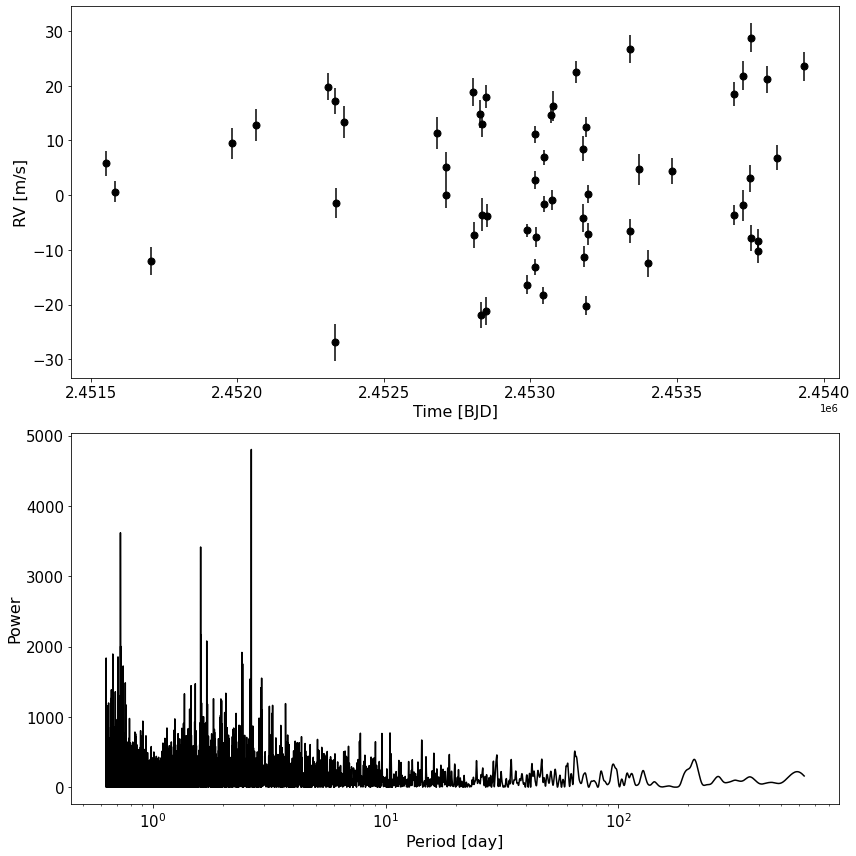

In [283]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.errorbar(x, y , e, ms=7, marker="o", ls="none", color="black")
plt.xlabel("Time [BJD]",fontdict={ 'size'   : 16})
plt.ylabel("RV [m/s]",fontdict={ 'size'   : 16})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.tight_layout()
plt.subplot(2, 1, 2)
plt.plot(2 * np.pi / f, pgram, color="black")
plt.xscale("log")
plt.xlabel("Period [day]",fontdict={ 'size'   : 16})
plt.ylabel("Power",fontdict={ 'size'   : 16})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.tight_layout()

In [284]:
print("The period with the highest power is: ", 2 * np.pi / f[np.where(pgram == np.max(pgram))][0], " day")

The period with the highest power is:  2.6439321027765184  day


In [285]:
print(limb_darkening_coefficients)

[0.6582879765982843, 0.6670380352309466, -0.44444666129208643, 0.11358343431251507]


# TRANSIT

## Read in transit data for GJ 436 b

In [286]:
tr_data = astropy.io.ascii.read("/Users/huihaoz/Documents/23 sp/5205/project2/UID_0057087_PLC_025.tbl.txt")
# tr_data = astropy.io.ascii.read("/Users/wang.12220/Downloads/UID_0013192_PLC_010.tbl.txt")
# tr_data = astropy.io.ascii.read("/Users/wang.12220/Downloads/1315925044.txt")


## Calculate the best-fit model

In [287]:
import pylightcurve as plc

# best-fit parameters from ExoFast

planet = plc.get_planet('gj436b')   ## Use this to get all the data for the star without manually entring everything


time_array = tr_data["BJD"].data
# time_array = tr_data["col1"].data

# Calculate Limb-darkening parameters
limb_darkening_coefficients = planet.filter('JOHNSON_B').limb_darkening_coefficients

# Calculate transiting light curve
flux_array = planet.transit_integrated(time_array, time_format='BJD_TDB', exp_time=120, time_stamp = 'mid', filter_name='JOHNSON_B', max_sub_exp_time=1)

# If the above report errors, comment out the above lines, try change False to True, and run the following:
if False:
    planet = plc.get_planet('gj436b')   ## Use this to get all the data for the star without manually entring everything

    time_array = tr_data["BJD"].data
    #time_array = tr_data["col1"].data

    # Calculate Limb-darkening parameters
    limb_darkening_coefficients = planet.filter('JOHNSON_B').limb_darkening_coefficients  ## New way to gt the coeffs

    flux_array = planet.transit_integrated(time_array, time_format='BJD_TDB', 
                                           exp_time=120, time_stamp = 'mid', filter_name='JOHNSON_B', max_sub_exp_time=1)

PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.
Fp/Fs estimated using A=0.15, e=1.0 for filter JOHNSON_B.


## Plot the best-fit model

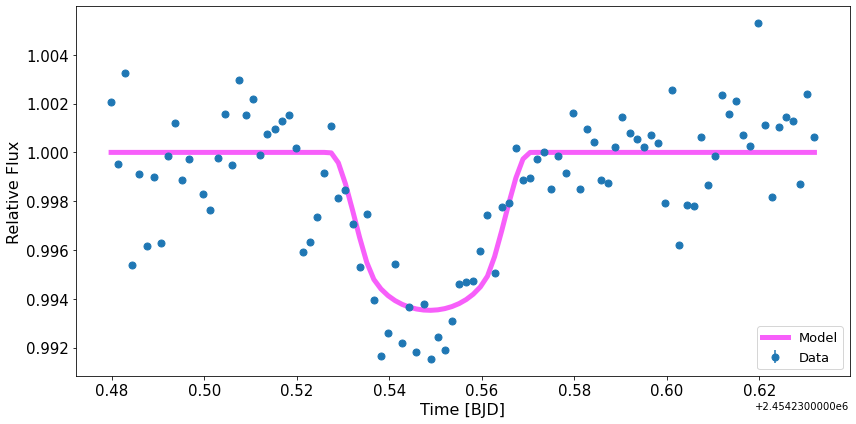

In [288]:
plt.figure(figsize=(12, 6))
plt.errorbar(tr_data["BJD"], tr_data["Relative_Flux"], tr_data["Accepted"]*0, ms=7, \
             marker="o", ls="none", label="Data", color="#1f77b4")
#no uncertainty are given.

plt.plot(time_array, flux_array, 'r-', lw=5, label="Model",color="#f75ffa")
plt.ylim(plt.ylim()[0], plt.ylim()[1])

plt.xlabel("Time [BJD]",fontdict={ 'size'   : 16})
plt.ylabel("Relative Flux",fontdict={ 'size'   : 16})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(prop={'size': 13},loc=4)
plt.tight_layout()

In [291]:
flux_array

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99998032, 0.99957285, 0.99871109, 0.99763383, 0.99651046,
       0.99549602, 0.99479368, 0.99440514, 0.99413038, 0.99392499,
       0.99377049, 0.99365811, 0.99358203, 0.99353935, 0.99352785,
       0.99354704, 0.99359761, 0.99368189, 0.993804  , 0.99397022,
       0.99418991, 0.99448691, 0.99492813, 0.99572528, 0.99678015,
       0.99791065, 0.99895168, 0.99972874, 0.99999776, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

$f=(\frac{R_p}{R_s})^2$

We have: 

$R_p = \sqrt{f} \cdot R_s$

In [331]:
flux_array.sort()

In [333]:
R_s = 0.4168*u.R_sun
f = 1-np.mean(flux_array[:5])
R_p = (f**(1/2) * R_s).to(u.R_earth)
R_p

<Quantity 3.64873756 earthRad>

Uncertainty: 

$\sigma_{R_{p}} = \frac{1}{2} \cdot \frac{\sigma_f}{f} \cdot R_p$

In [334]:
sig_rp = 0.5 * np.std(flux_array[:5])/f * R_p
sig_rp

<Quantity 0.00751564 earthRad>

# Density

$\rho = \frac{m}{(4/3) \cdot \pi R_p^3}$

In [339]:
rho = (m_p/((4/3)*np.pi * R_p**3)).to(u.kg/u.m**3)
rho

<Quantity 2434.00246735 kg / m3>

In [ ]:
sig_rp
sigm_p

Unvertainty: 
    
### $\sigma_{\rho}=\rho \cdot \sqrt{(\frac{\sigma_{m_p}}{m_p})^2+(\frac{\sigma_{R_p}}{R_p})^2+(\frac{\sigma_{R_p}}{R_p})^2+(\frac{\sigma_{R_p}}{R_p})^2}$

In [343]:
sig_rho = rho *((sigm_p/m_p)**2 + (sig_rp/R_p)**2 + (sig_rp/R_p)**2 + (sig_rp/R_p)**2)**(1/2)
sig_rho

<Quantity 18.38541182 kg / m3>

In [348]:
m_p

<Quantity 21.51688853 earthMass>

In [349]:
R_p

<Quantity 3.64873756 earthRad>

# Comparison section

In [345]:
import pandas as pd
data = pd.read_csv("PS_2020.12.15_09.21.06 copy.csv")

In [346]:
data["pl_rade"]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4302   NaN
4303   NaN
4304   NaN
4305   NaN
4306   NaN
Name: pl_rade, Length: 4307, dtype: float64

In [347]:
data["pl_bmasse"]

0       6165.6000
1       4684.8142
2       1525.5000
3       1481.0878
4        565.7374
          ...    
4302    6547.0000
4303     218.5310
4304     629.5950
4305    1313.2200
4306     890.0000
Name: pl_bmasse, Length: 4307, dtype: float64

In [367]:
ind_R = np.where((data["pl_rade"] < (1.2 * R_p/u.M_earth)) & (data["pl_rade"] > (0.8 * R_p/u.M_earth)))
ind_M = np.where((data["pl_bmasse"] < (1.2 * m_p/u.R_earth)) & (data["pl_bmasse"] > (0.8 * m_p/u.R_earth)))

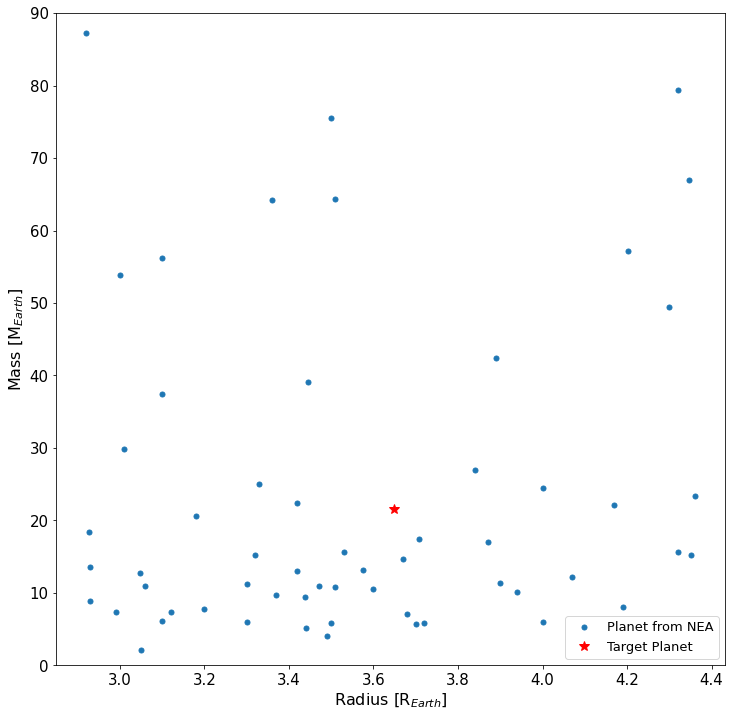

In [374]:
plt.figure(figsize=(12, 12))
plt.plot(data["pl_rade"][ind_R[0]], data["pl_bmasse"][ind_R[0]], ".",color = '#1f77b4',markersize=10,label= 'Planet from NEA')
plt.plot(R_p, m_p, "*",color = 'red',label ='Target Planet',markersize=10)
#plt.plot(x_line, y_line_1_t, color="#1f77b4",label="Sensitivity Limit of Transit",linewidth=3)
#plt.plot(x_line, y_line_1_r, color='#5ffa62',label="Sensitivity Limit of Radial Velocity",linewidth=3)
#plt.plot(x_line, y_line_1_d, color="#f75ffa",label="Sensitivity Limit of Direct Imaging",linewidth=3)


plt.xlabel(r"Radius [R$_{Earth}$]",fontdict={ 'size'   : 16})
plt.ylabel(r"Mass [M$_{Earth}$]",fontdict={ 'size'   : 16})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylim(0,90)
#plt.xlim(10**(-1),10**5.5)
plt.legend(prop={'size': 13},loc=4)

The More mass, the more density.

Seems that it at the middle of graph.

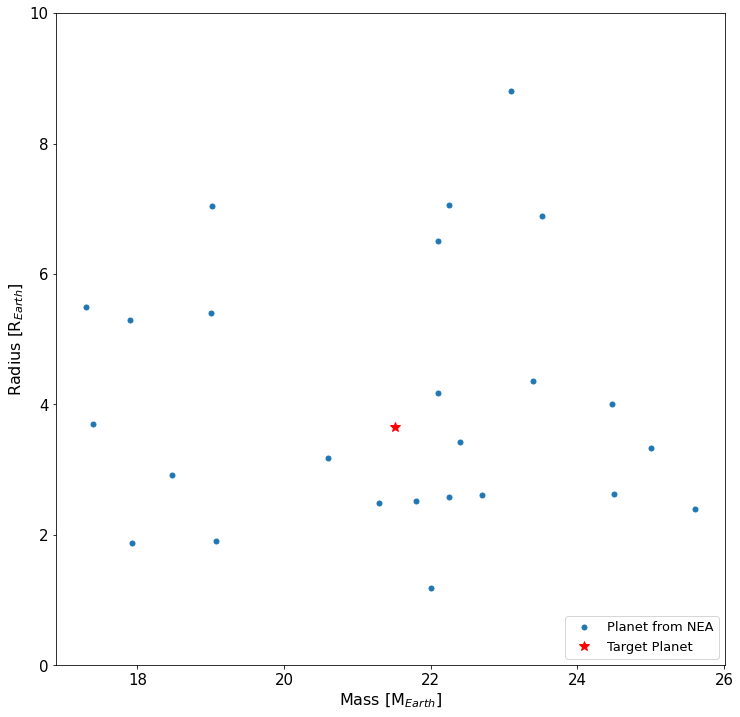

In [376]:
plt.figure(figsize=(12, 12))
plt.plot(data["pl_bmasse"][ind_M[0]],data["pl_rade"][ind_M[0]], ".",color = '#1f77b4',markersize=10,label= 'Planet from NEA')
plt.plot(m_p, R_p, "*",color = 'red',label ='Target Planet',markersize=10)
#plt.plot(x_line, y_line_1_t, color="#1f77b4",label="Sensitivity Limit of Transit",linewidth=3)
#plt.plot(x_line, y_line_1_r, color='#5ffa62',label="Sensitivity Limit of Radial Velocity",linewidth=3)
#plt.plot(x_line, y_line_1_d, color="#f75ffa",label="Sensitivity Limit of Direct Imaging",linewidth=3)


plt.xlabel(r"Mass [M$_{Earth}$]",fontdict={ 'size'   : 16})
plt.ylabel(r"Radius [R$_{Earth}$]",fontdict={ 'size'   : 16})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylim(0,10)
#plt.xlim(10**(-1),10**5.5)
plt.legend(prop={'size': 13},loc=4)

The more radius the less density.

Seem that the target planet at the middle of graph.

## M-R relation from Chen & Kipping (2016)

$21.516889M_⊕ = 10^{1.333}M_⊕$

$3.6487376R_⊕ = 10^{0.562}R_⊕$

![Note%20Feb%2020,%202023.png](https://raw.githubusercontent.com/Hu1haoZhang/astro-5205-project2-group6/main/Note%20Feb%2020%2C%202023.png)